In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from tsai.all import *

torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import psutil
import requests

from utils import *
from wingbeat_datasets import *
from wingbeat_models import *

print(f'Total RAM      : {bytes2GB(psutil.virtual_memory().total):5.2f} GB')
print(f'Available RAM  : {bytes2GB(psutil.virtual_memory().available):5.2f} GB\n')

/home/kalfasyan/anaconda3/envs/wbai/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


Available workers: 16
Total RAM      : 31.21 GB
Available RAM  : 26.23 GB



In [3]:
num_epochs = 35
batch_size = 32
batch_size_val = batch_size * 2
validation_split = .2
shuffle_dataset = True
num_workers = psutil.cpu_count()
random_seed= 42
setting = 'raw'
modeltype = 'conv1draw'
normalize = "sample"

In [4]:
transforms_list = [FilterWingbeat(setting='bandpass')]

if normalize == "whole":
    dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Y", transform=transforms.Compose(transforms_list)).clean()
    dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/L", transform=transforms.Compose(transforms_list)).clean()
    transformed_dataset = ConcatDataset([dmel1, dsuz1])
    trainval_dataloader = DataLoader(transformed_dataset, batch_size=batch_size, num_workers=num_workers)

    mean, std = calc_mean_std_1D(loader=trainval_dataloader)
    transforms_list += [Normalize(mean=mean, std=std, axes=(0,2))]
elif normalize == "sample":
    transforms_list += [Normalize()]
else:
    pass

dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Y", custom_label=[0], transform=transforms.Compose(transforms_list)).clean()
dmel2 = WingbeatsDataset(dsname="Melanogaster_RL/Z", custom_label=[0], transform=transforms.Compose(transforms_list)).clean()
dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/Y",      custom_label=[1], transform=transforms.Compose(transforms_list)).clean()
dsuz2 = WingbeatsDataset(dsname="Suzukii_RL/X",      custom_label=[1], transform=transforms.Compose(transforms_list)).clean()

Found 29002 in dataset: Melanogaster_RL/Y, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Nr. of valid wingbeats: 12819
Found 24763 in dataset: Melanogaster_RL/Z, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Nr. of valid wingbeats: 11778
Found 25732 in dataset: Suzukii_RL/Y, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]
Nr. of valid wingbeats: 17088
Found 10640 in dataset: Suzukii_RL/X, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]
Nr. of valid wingbeats: 7441


In [5]:
transformed_dataset = ConcatDataset([dmel1, dsuz1])
trainval_dataloader = DataLoader(transformed_dataset, batch_size=batch_size, num_workers=num_workers)
train_size = int(0.8 * len(transformed_dataset))
valid_size = len(transformed_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, valid_size])
test_dataset = ConcatDataset([dmel2, dsuz2])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

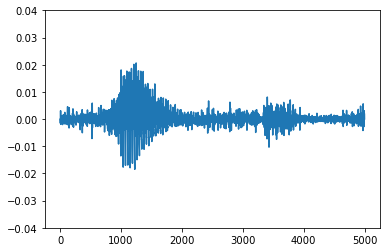

In [6]:
from IPython.display import Audio
sig = train_dataset[6][0]
plt.plot(sig.T); plt.ylim(-.04,.04)
Audio(sig, rate=8000, autoplay=True)

In [7]:
if setting.startswith('psd'):
    model = Conv1dNetPSD()
elif modeltype == 'conv1draw':
    model = Conv1dNetRAW()
elif modeltype == 'inception':
    model = nn.Sequential(
                    InceptionBlock(
                        in_channels=1, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    InceptionBlock(
                        in_channels=32*4, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.AdaptiveAvgPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Linear(in_features=4*32*1, out_features=2))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
early_stopping = EarlyStopping(patience=7, verbose=1)
# print(model)

In [8]:
# list(model.children())[0]

In [9]:
# test if everything works with mock input
# import torchsummary
# torchsummary.summary(model, (1,10000))
# x = torch.randn(32, 1, 5000)

# output = model(x)
# output

## Training

In [10]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(train_dataloader, desc='Training..\t'):        

        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
        
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()

    train_accuracy = correct_train / (len(train_dataloader)*batch_size) * 100.
    # Going through the validation set
    correct_valid = 0
    model.eval()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(valid_dataloader, desc='Validating..\t'):
        
        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()

        pred = model(x_batch)
        val_loss = criterion(pred, y_batch)
        correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
    valid_accuracy = correct_valid / (len(valid_dataloader)*batch_size_val) * 100.
    scheduler.step(val_loss)
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

        # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.2f}% loss: {loss:.3f},  val_loss: {val_loss:.3f} val_acc: {valid_accuracy:.2f}%")


Train on gpu: True


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Validation loss decreased (inf --> 5.051859).  Saving model ...
Epoch 0: train_acc: 85.57% loss: 0.447,  val_loss: 5.052 val_acc: 42.20%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Validation loss decreased (5.051859 --> 1.583335).  Saving model ...
Epoch 1: train_acc: 89.64% loss: 0.393,  val_loss: 1.583 val_acc: 58.38%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Validation loss decreased (1.583335 --> 0.743407).  Saving model ...
Epoch 2: train_acc: 90.62% loss: 0.433,  val_loss: 0.743 val_acc: 58.96%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 3: train_acc: 91.45% loss: 0.449,  val_loss: 0.897 val_acc: 56.22%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Validation loss decreased (0.743407 --> 0.663359).  Saving model ...
Epoch 4: train_acc: 92.18% loss: 0.557,  val_loss: 0.663 val_acc: 57.98%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 5: train_acc: 92.69% loss: 0.474,  val_loss: 1.351 val_acc: 57.26%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 6: train_acc: 93.19% loss: 0.458,  val_loss: 2.176 val_acc: 57.08%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Validation loss decreased (0.663359 --> 0.601552).  Saving model ...
Epoch 7: train_acc: 93.74% loss: 0.449,  val_loss: 0.602 val_acc: 64.83%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 8: train_acc: 94.15% loss: 0.458,  val_loss: 3.070 val_acc: 52.66%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Validation loss decreased (0.601552 --> 0.442988).  Saving model ...
Epoch 9: train_acc: 94.52% loss: 0.500,  val_loss: 0.443 val_acc: 83.39%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 10: train_acc: 94.88% loss: 0.425,  val_loss: 1.880 val_acc: 70.26%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 11: train_acc: 95.14% loss: 0.330,  val_loss: 0.829 val_acc: 58.61%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 12: train_acc: 95.50% loss: 0.330,  val_loss: 0.648 val_acc: 68.40%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch    14: reducing learning rate of group 0 to 1.0000e-03.
Epoch 13: train_acc: 95.93% loss: 0.481,  val_loss: 1.436 val_acc: 58.59%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Validation loss decreased (0.442988 --> 0.191859).  Saving model ...
Epoch 14: train_acc: 96.75% loss: 0.062,  val_loss: 0.192 val_acc: 89.20%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 15: train_acc: 97.21% loss: 0.060,  val_loss: 0.393 val_acc: 79.50%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 16: train_acc: 97.47% loss: 0.048,  val_loss: 0.207 val_acc: 91.77%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 17: train_acc: 97.56% loss: 0.039,  val_loss: 0.344 val_acc: 84.91%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch    19: reducing learning rate of group 0 to 1.0000e-04.
Epoch 18: train_acc: 97.84% loss: 0.035,  val_loss: 0.210 val_acc: 92.37%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Validation loss decreased (0.191859 --> 0.163645).  Saving model ...
Epoch 19: train_acc: 98.20% loss: 0.041,  val_loss: 0.164 val_acc: 93.97%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Validation loss decreased (0.163645 --> 0.142900).  Saving model ...
Epoch 20: train_acc: 98.18% loss: 0.054,  val_loss: 0.143 val_acc: 93.95%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 21: train_acc: 98.22% loss: 0.063,  val_loss: 0.158 val_acc: 94.03%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 22: train_acc: 98.24% loss: 0.067,  val_loss: 0.166 val_acc: 93.97%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Validation loss decreased (0.142900 --> 0.129846).  Saving model ...
Epoch 23: train_acc: 98.23% loss: 0.049,  val_loss: 0.130 val_acc: 93.85%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Validation loss decreased (0.129846 --> 0.125435).  Saving model ...
Epoch 24: train_acc: 98.33% loss: 0.046,  val_loss: 0.125 val_acc: 93.83%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 25: train_acc: 98.39% loss: 0.055,  val_loss: 0.170 val_acc: 93.90%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 26: train_acc: 98.37% loss: 0.054,  val_loss: 0.255 val_acc: 92.65%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 27: train_acc: 98.29% loss: 0.060,  val_loss: 0.166 val_acc: 93.98%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch    29: reducing learning rate of group 0 to 1.0000e-05.
Epoch 28: train_acc: 98.36% loss: 0.055,  val_loss: 0.135 val_acc: 93.80%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 29: train_acc: 98.44% loss: 0.033,  val_loss: 0.158 val_acc: 94.07%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 30: train_acc: 98.42% loss: 0.049,  val_loss: 0.162 val_acc: 94.03%


Validating..	: 100%|██████████| 94/94 [00:01<00:00, 77.26it/s] 

Early stopping


## Testing

### testing on datasets with same conditions

In [260]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

Train on gpu: True


In [261]:
test_dataset = ConcatDataset([dmel2, dsuz2])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

def test(model, test_dataloader):
    correct_test = 0
    model.eval()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(test_dataloader, desc='Testing..\t'):

        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()

        pred = model(x_batch)
        val_loss = criterion(pred, y_batch)
        correct_test += (pred.argmax(axis=1) == y_batch).float().sum().item()
    test_accuracy = correct_test / (len(test_dataloader)*batch_size_val) * 100.
    print(test_accuracy)

In [262]:
test(model,test_dataloader)

Testing..	: 100%|██████████| 301/301 [00:02<00:00, 118.07it/s]

94.35735049833886


### testing on ALL available datasets (collected with the same sensor)

In [13]:
ds1 = WingbeatsDataset(dsname="Suzukii_RL/R", custom_label=[1], transform=transforms.Compose(transforms_list)).clean()
ds2 = WingbeatsDataset(dsname="Suzukii_RL/L", custom_label=[1], transform=transforms.Compose(transforms_list)).clean()
ds3 = WingbeatsDataset(dsname="Melanogaster_RL/Z", custom_label=[0], transform=transforms.Compose(transforms_list)).clean()
ds4 = WingbeatsDataset(dsname="Melanogaster_RL/X", custom_label=[0], transform=transforms.Compose(transforms_list)).clean()
ds5 = WingbeatsDataset(dsname="Melanogaster_RL/W", custom_label=[0], transform=transforms.Compose(transforms_list)).clean()

dslist = [ds1, ds2, ds3, ds4, ds5]#, dmel2, dsuz2]

test_dataset = ConcatDataset(dslist)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

test(model,test_dataloader)

Found 14348 in dataset: Suzukii_RL/R, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]
Nr. of valid wingbeats: 10372
Found 21940 in dataset: Suzukii_RL/L, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]
Nr. of valid wingbeats: 14729


Testing..	:   0%|          | 0/600 [00:00<?, ?it/s]

Found 24763 in dataset: Melanogaster_RL/Z, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Nr. of valid wingbeats: 11778
Found 2086 in dataset: Melanogaster_RL/X, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Nr. of valid wingbeats: 646
Found 1882 in dataset: Melanogaster_RL/W, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Nr. of valid wingbeats: 875


Testing..	: 100%|██████████| 600/600 [00:05<00:00, 111.05it/s]

86.32291666666667


In [155]:
@torch.no_grad()
def get_all_preds(model, loader):
#     model = model.to('cuda', dtype=torch.float)
    model.eval()

    results = {}
    results['preds'] = torch.tensor([])
    results['fnames'] = ()
    results['labels'] = torch.tensor([])
    results['idx'] = torch.tensor([])

    for x_batch,y_batch,path_batch,idx_batch in tqdm(loader):

        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)

        results['fnames'] += path_batch
        results['labels'] = torch.cat( (results['labels'], y_batch), dim=0)
        results['idx'] = torch.cat( (results['idx'], idx_batch), dim=0)

        preds = model(x_batch.float())
        results['preds'] = torch.cat(
            (results['preds'], preds)
            ,dim=0
        )
    return results
model = model.to('cpu', dtype=torch.float)
results = get_all_preds(model, test_dataloader)

def softmax_out(x):
    return np.argmax(F.softmax(x.reshape(1,-1), dim=1), axis=1).tolist()[0]

results['preds_labels'] = list(map(softmax_out, results['preds']))

100%|██████████| 600/600 [01:49<00:00,  5.48it/s]


In [257]:
df = pd.DataFrame(results)
df['humidity'] = df.fnames.apply(lambda x: x.split('/')[-1].split('_')[-1][:-4]).astype(float).values
df['temperature'] = df.fnames.apply(lambda x: x.split('/')[-1].split('_')[-3]).astype(float).values
df.sample(3)

,preds,fnames,labels,idx,preds_labels,humidity,temperature
27452,"(tensor(4.2523), tensor(-4.3155))",/home/kalfasyan/data/wingbeats/Melanogaster_RL/Z/D_20_12_04_18_48_47/F201204_211108_170_G_050_T_21.8_H_105.3.wav,0.0,4987.0,0,105.3,21.8
15009,"(tensor(-9.0598), tensor(9.0092))",/home/kalfasyan/data/wingbeats/Suzukii_RL/L/D_20_08_24_13_19_40/F200824_132011_156_G_050_T_21.8_H_101.4.wav,1.0,6821.0,1,101.4,21.8
8124,"(tensor(-11.2704), tensor(11.1093))",/home/kalfasyan/data/wingbeats/Suzukii_RL/R/D_20_07_17_14_46_45/F200717_144826_091_G_050_T_21.8_H_-5.0.wav,1.0,11256.0,1,-5.0,21.8


## Plotting

In [197]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()
ticklabels = ['Melanogaster','Suzukii']

True vs Predicted


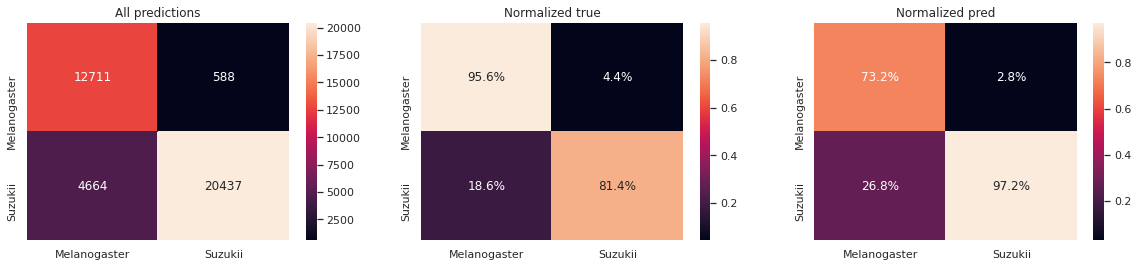

In [213]:
plt.figure(figsize=(20,4));
print("True vs Predicted")
plt.subplot(1,3,1); plt.title('All predictions');
cm = confusion_matrix(y_true=df.labels.astype(int), y_pred=df.preds_labels, normalize=None)
sns.heatmap(cm, annot=True, fmt='g', xticklabels=ticklabels, yticklabels=ticklabels);
plt.subplot(1,3,2); plt.title('Normalized true')
cm = confusion_matrix(y_true=df.labels.astype(int), y_pred=df.preds_labels, normalize='true')
sns.heatmap(cm, annot=True, fmt='.1%', xticklabels=ticklabels, yticklabels=ticklabels);
plt.subplot(1,3,3); plt.title('Normalized pred')
cm = confusion_matrix(y_true=df.labels.astype(int), y_pred=df.preds_labels, normalize='pred')
sns.heatmap(cm, annot=True, fmt='.1%', xticklabels=ticklabels, yticklabels=ticklabels);

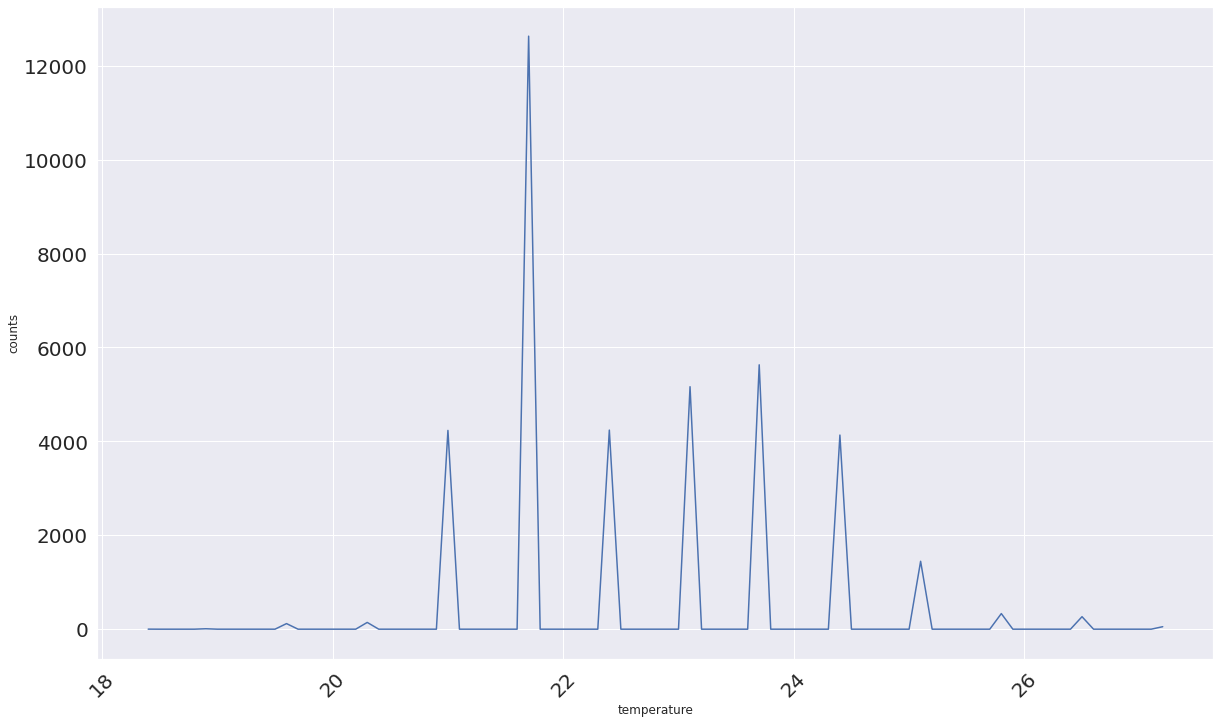

In [254]:
from utils import np_hist
plt.figure(figsize=(20,12))
# np_hist(df, 'humidity', fs=20)
np_hist(df, 'temperature', fs=20)